# Density Module - FloatCF
## Grain Size Determination
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles. This example shows how [correlation functions](https://en.wikipedia.org/wiki/Correlation_function) can be used to approximate the grain size within a system.

In [1]:
import freud
import numpy as np
import matplotlib.pyplot as plt

To show the correlation function, we need a pretend data set. We start with a phase separated Ising lattice and assign type values, either **blue (-1)** or **red (+1)**, to generate "grains."

To make the pretend data set, we create a large number of **blue (-1)** particles on a square grid. Then we place grain centers on a larger grid and draw grain radii from a normal distribution. We color the particles **red (+1)** if their distance from a grain center is less than the grain radius.

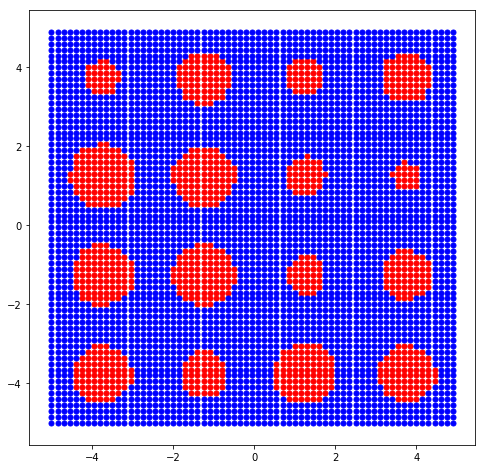

In [2]:
# Set up the system
box = freud.box.Box.square(L=10)
dx = 0.15
num_grains = 4
dg = box.Lx/num_grains
points = np.array([[i, j, 0]
                   for j in np.arange(-box.Ly/2, box.Ly/2, dx)
                   for i in np.arange(-box.Lx/2, box.Lx/2, dx)])
values = np.array([-1 for p in points])
centroids = [[i*dg + 0.5*dg, j*dg + 0.5*dg, 0]
             for i in range(num_grains) for j in range(num_grains)]
grain_radii = np.abs(np.random.normal(size=num_grains**2, loc=0.25*dg, scale=0.05*dg))
for center, radius in zip(centroids, grain_radii):
    lc = freud.locality.LinkCell(box, radius).compute(box, points, [center])
    for i in lc.nlist.index_i:
        values[i] = 1

plt.figure(figsize=(8, 8))
plt.scatter(points[values > 0, 0],
            points[values > 0, 1],
            marker='o', color='red', s=25)
plt.scatter(points[values < 0, 0],
            points[values < 0, 1],
            marker='o', color='blue', s=25)
plt.show()

This system is **phase-separated** because the red particles are generally near one another, and so are the blue particles. However, there is some **length scale** at which the phase separation is no longer visible. Imagine looking at this image from a far distance away: the red and blue regions would be indistinguishable, and the picture would appear purple.

We can use the correlation lengths between the grain centers and the surrounding red and blue particles to find where the grains end. First, we need to locate the centers of the grains using `freud.cluster`.

In [3]:
cl = freud.cluster.Cluster(box=box, rcut=2*dx)
cluster_idx = cl.computeClusters(points[values > 0, :]).cluster_idx

Now we'll find the cluster centroids (the grain centers).

In [4]:
clp = freud.cluster.ClusterProperties(box=box)
clp.computeProperties(points[values > 0, :], cl.cluster_idx)

Now we create a `freud.density.FloatCF` compute object, to compute the correlation function.

In [5]:
fcf = freud.density.FloatCF(rmax=0.5*box.Lx/num_grains, dr=dx)
fcf.reset()

Now we compute the product of type values. Knowing that two sites with the same type will have a product of 1, we can estimate the radius of a grain as the smallest value of $r$ such that $\langle p \ast q \rangle (r) < 0$, where the set $p$ represents our red and blue particles and $q$ represents the grain centers.

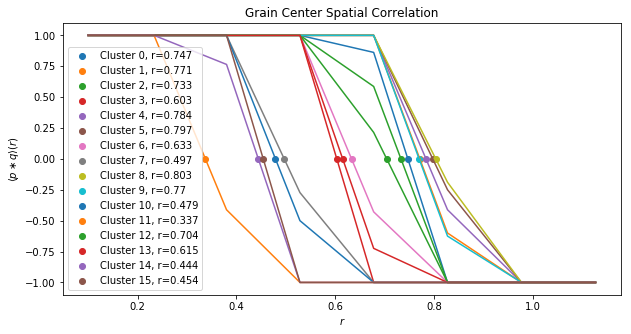

In [6]:
plt.figure(figsize=(10, 5))
weights = []
sizes = []
measured_grain_radii = []
for cluster_id in range(cl.num_clusters):
    fcf.compute(box=box,
                ref_points=points,  # all points in the system
                ref_values=values,   # all types in the system
                points=[clp.cluster_COM[cluster_id]],
                values=[1])
    # get the center of the histogram bins
    r = fcf.R
    # get the value of the histogram bins
    y = fcf.RDF
    grainsize = y[y > 0][-1] * (r[y < 0][0]-r[y > 0][-1]) / \
        (y[y > 0][-1]-y[y < 0][0]) + r[y > 0][-1]
    measured_grain_radii.append(grainsize)
    
    plt.plot(r, y)
    plt.scatter(x=grainsize, y=0, label='Cluster {}, r={}'.format(
        cluster_id, round(grainsize, 3)))
    
plt.title("Grain Center Spatial Correlation")
plt.xlabel(r"$r$")
plt.ylabel(r"$\langle p \ast q \rangle (r)$")
plt.legend()
plt.show()

This table shows the grain radii we expected compared to the ones we computed.

In [7]:
print('Actual Radius\tMeasured Radius')
for actual, measured in zip(sorted(grain_radii), sorted(measured_grain_radii)):
    print('{:.4f}\t\t{:.4f}'.format(actual, measured))

Actual Radius	Measured Radius
0.3595		0.3372
0.4396		0.4444
0.4903		0.4543
0.4997		0.4790
0.5079		0.4967
0.5897		0.6032
0.6352		0.6151
0.6484		0.6330
0.6787		0.7042
0.7356		0.7330
0.7402		0.7470
0.7682		0.7698
0.7799		0.7712
0.7852		0.7837
0.7940		0.7974
0.8232		0.8035
